In [1]:
import sys
sys.argv = ['']
sys.path.append("../..")

from src.grid_world import GridWorld
import numpy as np
import random

In [2]:
class PolicyIteration:
    def __init__(self, env, gamma=0.9, theta=1e-4):
        """
        Policy Iteration for a GridWorld environment.

        Args:
            env: GridWorld instance
            gamma: discount factor
            theta: convergence threshold
        """
        self.env = env
        self.gamma = gamma
        self.theta = theta
        self.num_states = env.num_states
        self.num_actions = len(env.action_space)
        self.V = np.zeros(self.num_states)
        self.policy = np.zeros((self.num_states, self.num_actions))

    def policy_evaluation(self):
        """
        Evaluate the current policy to update the value function V(s).
        """
        while True:
            delta = 0
            for s in range(self.num_states):
                x = s % self.env.env_size[0]
                y = s // self.env.env_size[0]
                state = (x, y)

                if state == self.env.target_state or state in self.env.forbidden_states:
                    continue  # 目标状态和禁止状态值不更新

                v = self.V[s]
                # Calculate the maximum Q value over all actions
                q_values = []
                for a_idx, action in enumerate(self.env.action_space):
                    next_state, reward = self.env._get_next_state_and_reward(state, action)
                    next_s = next_state[1] * self.env.env_size[0] + next_state[0]
                    q = reward + self.gamma * self.V[next_s]
                    q_values.append(q)

                self.V[s] = max(q_values)
                delta = max(delta, abs(v - self.V[s]))

            if delta < self.theta:
                break

    def policy_improvement(self):
        """
        Improve the current policy based on the updated value function V(s).
        Returns True if the policy is stable (no changes), False otherwise.
        """
        policy_stable = True
        for s in range(self.num_states):
            x = s % self.env.env_size[0]
            y = s // self.env.env_size[0]
            state = (x, y)

            if state == self.env.target_state or state in self.env.forbidden_states:
                continue

            old_action = np.argmax(self.policy[s])

            q_values = []
            for a_idx, action in enumerate(self.env.action_space):
                next_state, reward = self.env._get_next_state_and_reward(state, action)
                next_s = next_state[1] * self.env.env_size[0] + next_state[0]
                q = reward + self.gamma * self.V[next_s]
                q_values.append(q)

            best_action_idx = np.argmax(q_values)

            # 更新策略为确定性策略
            self.policy[s] = np.eye(self.num_actions)[best_action_idx]

            if old_action != best_action_idx:
                policy_stable = False

        return policy_stable

    def run(self):
        """
        Run the Policy Iteration algorithm.
        """
        iteration = 0
        while True:
            self.policy_evaluation()
            policy_stable = self.policy_improvement()
            iteration += 1
            if policy_stable:
                break

        # 根据最终 V(s) 提取策略
        self._extract_policy()

    def _extract_policy(self):
        """
        Extract the optimal deterministic policy from V(s)
        """
        for s in range(self.num_states):
            x = s % self.env.env_size[0]
            y = s // self.env.env_size[0]
            state = (x, y)

            if state == self.env.target_state or state in self.env.forbidden_states:
                continue

            q_values = []
            for a_idx, action in enumerate(self.env.action_space):
                next_state, reward = self.env._get_next_state_and_reward(state, action)
                next_s = next_state[1] * self.env.env_size[0] + next_state[0]
                q = reward + self.gamma * self.V[next_s]
                q_values.append(q)

            best_action_idx = np.argmax(q_values)
            self.policy[s, best_action_idx] = 1.0  # 确定性策略

    def render(self, precision=1):
        """
        Render the GridWorld with the optimal value function and policy.
        """
        self.env.render_static(values=self.V, policy=self.policy, precision=precision)


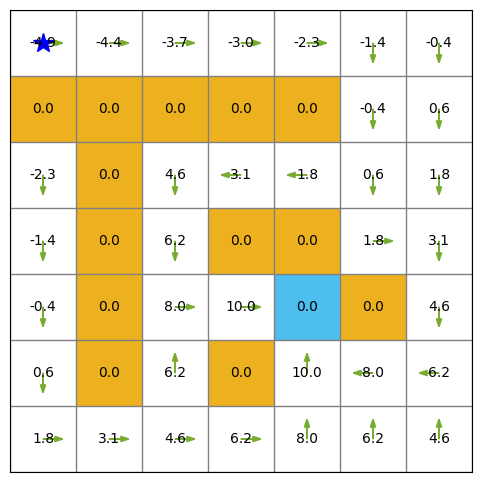

In [3]:
env = GridWorld()
env.reset()
vi = PolicyIteration(env, gamma=0.9, theta=1e-4)
vi.run()
vi.render(precision=1)
